In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import numpy as np
import scipy as sp
import patsy
from patsy.contrasts import Helmert
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from tableone import TableOne
from statsmodels.graphics.factorplots import interaction_plot
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.packages import importr
from rpy2.robjects import Formula
utils = importr('utils')
#utils.install_packages('glmnet')
stats = importr('stats')
glmnet = importr('glmnet')
lme4 = importr('lme4')
#library(lmerTest)
R = ro.r

/afs/crc.nd.edu/user/l/lfaust/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<b><font size="4">Setup + cleaning</font></b>

In [2]:
#Helper functions
def AgeType(x):
    x = int(x)
    if(pd.isnull(x)):
        return(-1)
    if(x<=18):
        return 18
    if(x<=24):
        return 24
    if(x<=53):
        return 53
    if(x<=77):
        return 77
    if(x<=89):
        return 89
    if(x>90):
        return 90
    return 0

def DiagCodeType(x):
    if(pd.isnull(x)):
        return(0)
    if(not str(x).isnumeric()):
        return 1
    x = int(str(x[0:3]))
    if((x>=0)&(x<=139)):
        return 2
    if((x>=140)&(x<=239)):
        return 3
    if((x>=240)&(x<=279)):
        return 4
    if((x>=280)&(x<=289)):
        return 5
    if((x>=290)&(x<=319)):
        return 6
    if((x>=320)&(x<=389)):
        return 7
    if((x>=390)&(x<=459)):
        return 8
    if((x>=460)&(x<=519)):
        return 9
    if((x>=520)&(x<=579)):
        return 10
    if((x>=580)&(x<=629)):
        return 11
    if((x>=630)&(x<=679)):
        return 12
    if((x>=680)&(x<=709)):
        return 13
    if((x>=710)&(x<=739)):
        return 14
    if((x>=740)&(x<=759)):
        return 15
    if((x>=760)&(x<=779)):
        return 16
    if((x>=780)&(x<=799)):
        return 17
    if((x>=800)&(x<=999)):
        return 18
    return 0

In [3]:
df = pd.read_pickle('pat_data.pkl')

In [4]:
#Cleaning
df['Primary_Diag_Code'] = df['Primary_Diag'].apply(lambda x: DiagCodeType(x))
df = df[df.Primary_Diag_Code > 0]
df['Age'] = df['Age'].apply(lambda x: AgeType(x))
df = df.replace(to_replace=['UNABLE TO OBTAIN','UNKNOWN/NOT SPECIFIED','PATIENT DECLINED TO ANSWER'], value='UNKNOWN')
df = df.replace(to_replace=['ASIAN - CHINESE','ASIAN - VIETNAMESE','ASIAN - ASIAN INDIAN','ASIAN - FILIPINO','ASIAN - KOREAN','ASIAN - OTHER','ASIAN - CAMBODIAN','ASIAN - JAPANESE','ASIAN - THAI'], value='ASIAN')
df = df.replace(to_replace=['HISPANIC/LATINO - PUERTO RICAN','HISPANIC/LATINO - DOMINICAN','HISPANIC/LATINO - GUATEMALAN','HISPANIC/LATINO - SALVADORAN','HISPANIC/LATINO - CUBAN','HISPANIC/LATINO - MEXICAN','HISPANIC/LATINO - COLOMBIAN','HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)','HISPANIC/LATINO - HONDURAN'], value='HISPANIC OR LATINO')
df = df.replace(to_replace=['BLACK/AFRICAN AMERICAN','BLACK/CAPE VERDEAN','BLACK/HAITIAN','BLACK/AFRICAN'], value='BLACK')
df = df.replace(to_replace=['WHITE - RUSSIAN','WHITE - OTHER EUROPEAN','WHITE - BRAZILIAN','WHITE - EASTERN EUROPEAN'], value='WHITE')
df = df.replace(to_replace=['MULTI RACE ETHNICITY','AMERICAN INDIAN/ALASKA NATIVE','PORTUGUESE','MIDDLE EASTERN','NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER','SOUTH AMERICAN','CARIBBEAN ISLAND','AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE'], value='OTHER')
df = df[df.Admit_Type != 'NEWBORN']
df = df[df.Admit_Unit != 'NICU']
df = df[df.Lag_Time > 0]
df = df.replace(to_replace=['TRANSFER FROM SKILLED NUR','TRANSFER FROM OTHER HEALT','TRSF WITHIN THIS FACILITY','TRANSFER FROM HOSP/EXTRAM'], value='TRANSFER')
df = df[df.Admit_LOC.isin(['EMERGENCY ROOM ADMIT','TRANSFER','CLINIC REFERRAL/PREMATURE','PHYS REFERRAL/NORMAL DELI'])]

df.loc[(df.DOW == 5)|(df.DOW == 6), 'weekend'] = 1
#df.loc[(df.DOW == 6)&(df.TOD == 'Night'), 'weekend'] = 1

df.weekend = df.weekend.fillna(0)

df['LOS_ICU'] = pd.qcut(df['LOS_ICU'], 4,False)
df['Hospital_LOS'] = pd.qcut(df['Hospital_LOS'], 4,False)

In [5]:
f = "Expire ~ 1 + C(Primary_Diag_Code) + C(Admit_Unit) + C(Admit_LOC) + C(Admit_Type) + C(Insurance) + LOS_ICU + C(Transfer_Flag) + Age  + Hospital_LOS + Lag_Time + C(TOD) + C(weekend) + C(Admit_LOC) + C(Gender) + C(Gender)*C(weekend) + C(Admit_LOC)*C(weekend)"
y, X = patsy.dmatrices(f, df, return_type='dataframe')
print(sm.Logit(y, X).fit_regularized().summary())

/afs/crc.nd.edu/user/l/lfaust/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/afs/crc.nd.edu/user/l/lfaust/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.33179895835673695
            Iterations: 326
            Function evaluations: 333
            Gradient evaluations: 326
                           Logit Regression Results                           
Dep. Variable:                 Expire   No. Observations:                30738
Model:                          Logit   Df Residuals:                    30696
Method:                           MLE   Df Model:                           41
Date:                Mon, 05 Mar 2018   Pseudo R-squ.:                  0.1735
Time:                        19:49:19   Log-Likelihood:                -10199.
converged:                       True   LL-Null:                       -12340.
                                        LLR p-value:                     0.000
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

<b><font size="4">Summary stats</font></b>

In [6]:
#summary statistics for each variable
columns = ['Admit_Type', 'Admit_LOC', 'Insurance', 'Expire', 'Admit_Unit', 'LOS_ICU', 'NoICU', 'Transfer_Flag', 'Age', 'Hospital_LOS', 'TOD', 'Primary_Diag_Code', 'Ethnicity', 'Gender']
groupby = 'weekend'
pval = True
TableOne(df, columns=columns, categorical=columns, groupby=groupby, pval=pval).tableone

Grouped by weekend                 \
                                                        isnull            0.0   
variable          level                                                         
n                                                                       24062   
Admit_LOC         CLINIC REFERRAL/PREMATURE                  0   4666 (19.39)   
                  EMERGENCY ROOM ADMIT                            9289 (38.6)   
                  PHYS REFERRAL/NORMAL DELI                      5215 (21.67)   
                  TRANSFER                                       4892 (20.33)   
Admit_Type        ELECTIVE                                   0   4543 (18.88)   
                  EMERGENCY                                     19016 (79.03)   
                  URGENT                                           503 (2.09)   
Admit_Unit        CCU                                        0   3382 (14.06)   
                  CSRU                                           5784 (24.04)   
                  MICU                                           7744 (32.18)   
                  SICU                                            3899 (16.2)   
                  TSICU                                          3253 (13.52)   
Age               18                                         0     137 (0.57)   
                  24                                               559 (2.32)   
                  53                                              5703 (23.7)   
                  77                                             11646 (48.4)   
                  89                                             4838 (20.11)   
                  90                                               1179 (4.9)   
Ethnicity         ASIAN                                      0     556 (2.31)   
                  BLACK                                           1614 (6.71)   
                  HISPANIC OR LATINO                               731 (3.04)   
                  OTHER                                            647 (2.69)   
                  UNKNOWN                                        3420 (14.21)   
                  WHITE                                         17094 (71.04)   
Expire            0                                          0  20920 (86.94)   
                  1                                              3142 (13.06)   
Gender            F                                          0  10368 (43.09)   
                  M                                             13694 (56.91)   
Hospital_LOS      0                                          0   5621 (23.36)   
                  1                                              6125 (25.46)   
                  2.0                                            6388 (26.55)   
                  3.0                                            5928 (24.64)   
Insurance         Government                                 0     683 (2.84)   
                  Medicaid                                        1833 (7.62)   
                  Medicare                                      12668 (52.65)   
                  Private                                        8555 (35.55)   
                  Self Pay                                         323 (1.34)   
LOS_ICU           0                                          2   6193 (25.74)   
                  1                                              6049 (25.14)   
                  2.0                                            5932 (24.66)   
                  3.0                                            5886 (24.46)   
NoICU             0                                          0   12345 (51.3)   
                  1                                              11717 (48.7)   
Primary_Diag_Code 1                                          0      63 (0.26)   
                  2.0                                             1584 (6.58)   
                  3.0                                             2050 (8.5

<b><font size="4">logistic regression with 2nd order interactions pertaining to weekend</font></b>

In [7]:
f = "Expire ~ 1 + C(TOD)*C(weekend) + C(Admit_LOC, Treatment(reference='CLINIC REFERRAL/PREMATURE'))*C(weekend) + C(Admit_Type, Treatment(reference='ELECTIVE'))*C(weekend) + C(Admit_Unit, Treatment(reference='TSICU'))*C(weekend) + C(Age)*C(weekend) + C(Gender)*C(weekend) + C(Ethnicity, Treatment(reference='ASIAN'))*C(weekend) + C(Hospital_LOS, Treatment(reference=1))*C(weekend) + C(Insurance, Treatment(reference='Medicare'))*C(weekend) + C(LOS_ICU, Treatment(reference=0))*C(weekend) + C(NoICU)*C(weekend) + C(Primary_Diag_Code, Treatment(reference=11))*C(weekend) + C(Transfer_Flag)*C(weekend)"
y, X = patsy.dmatrices(f, df, return_type='dataframe')
res = sm.Logit(y, X).fit_regularized()
res.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.31664524441931635
            Iterations: 756
            Function evaluations: 756
            Gradient evaluations: 756


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Expire   No. Observations:                30738
Model:                          Logit   Df Residuals:                    30638
Method:                           MLE   Df Model:                           99
Date:                Mon, 05 Mar 2018   Pseudo R-squ.:                  0.2112
Time:                        19:49:34   Log-Likelihood:                -9733.0
converged:                       True   LL-Null:                       -12340.
                                        LLR p-value:                     0.000
=================================================================================================================================================================================
                                                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                        -6.5981      0.614    -10.748      0.000      -7.801      -5.395
C(TOD)[T.Night]                                                                                                   0.0445      0.044      1.015      0.310      -0.041       0.130
C(weekend)[T.1.0]                                                                                                 1.8119      0.941      1.925      0.054      -0.033       3.656
C(Admit_LOC, Treatment(reference='CLINIC REFERRAL/PREMATURE'))[T.EMERGENCY ROOM ADMIT]                            0.4134      0.058      7.153      0.000       0.300       0.527
C(Admit_LOC, Treatment(reference='CLINIC REFERRAL/PREMATURE'))[T.PHYS REFERRAL/NORMAL DELI]                       0.3486      0.145      2.412      0.016       0.065       0.632
C(Admit_LOC, Treatment(reference='CLINIC REFERRAL/PREMATURE'))[T.TRANSFER]                                        0.2382      0.071      3.364      0.001       0.099       0.377
C(Admit_Type, Treatment(reference='ELECTIVE'))[T.EMERGENCY]                                                       1.6002      0.165      9.713      0.000       1.277       1.923
C(Admit_Type, Treatment(reference='ELECTIVE'))[T.URGENT]                                                          1.5157      0.205      7.394      0.000       1.114       1.917
C(Admit_Unit, Treatment(reference='TSICU'))[T.CCU]                                                               -0.5568      0.090     -6.155      0.000      -0.734      -0.379
C(Admit_Unit, Treatment(reference='TSICU'))[T.CSRU]                                                              -1.0813      0.107    -10.063      0.000      -1.292      -0.871
C(Admit_Unit, Treatment(reference='TSICU'))[T.MICU]                                                               0.0097      0.075      0.129      0.897      -0.138       0.158
C(Admit_Unit, Treatment(reference='TSICU'))[T.SICU]                                                               0.0320      0.080      0.399      0.690      -0.125       0.189
C(Age)[T.24]                                                                                                      0.3498      0.579      0.604      0.546      -0.786       1.485
C(Age)[T.53]                                                                                                      1.2608      0.537      2.350      0.019       0.209       2.312
C(Age)[T.77]                                                                                                      1.7508      0.536      3.264      0.001       0.700       2.802
C(Age)[T.89]                         

<b><font size="4">testing significance of interactions</font></b>

In [8]:
rdf=pandas2ri.py2ri(df)

factor(TOD)*factor(weekend)

In [9]:
full = Formula("Expire ~ factor(Admit_LOC)*factor(weekend) + factor(Admit_Type)*factor(weekend) + factor(Admit_Unit)*factor(weekend) + factor(Age)*factor(weekend) + factor(Gender)*factor(weekend) + factor(Ethnicity)*factor(weekend) + factor(Hospital_LOS)*factor(weekend) + factor(Insurance)*factor(weekend) + factor(LOS_ICU)*factor(weekend) + factor(NoICU)*factor(weekend) + factor(Primary_Diag_Code)*factor(weekend) + factor(Transfer_Flag)*factor(weekend)")
null = Formula("Expire ~ factor(Admit_LOC)*factor(weekend) + factor(Admit_Type)*factor(weekend) + factor(Admit_Unit)*factor(weekend) + factor(Age)*factor(weekend) + factor(Gender)*factor(weekend) + factor(Ethnicity)*factor(weekend) + factor(Hospital_LOS)*factor(weekend) + factor(Insurance)*factor(weekend) + factor(LOS_ICU)*factor(weekend) + factor(NoICU)*factor(weekend) + factor(Primary_Diag_Code)*factor(weekend) + factor(Transfer_Flag)*factor(weekend)")
m0 = R.glm(full,data=rdf,family=ro.r('binomial(link="logit")'))
m1 = R.glm(null,data=rdf,family=ro.r('binomial(link="logit")'))
print(R.anova(m0, m1, test ="Chisq"))

Analysis of Deviance Table

Model 1: Expire ~ factor(Admit_LOC) * factor(weekend) + factor(Admit_Type) * 
    factor(weekend) + factor(Admit_Unit) * factor(weekend) + 
    factor(Age) * factor(weekend) + factor(Gender) * factor(weekend) + 
    factor(Ethnicity) * factor(weekend) + factor(Hospital_LOS) * 
    factor(weekend) + factor(Insurance) * factor(weekend) + factor(LOS_ICU) * 
    factor(weekend) + factor(NoICU) * factor(weekend) + factor(Primary_Diag_Code) * 
    factor(weekend) + factor(Transfer_Flag) * factor(weekend)
Model 2: Expire ~ factor(Admit_LOC) * factor(weekend) + factor(Admit_Type) * 
    factor(weekend) + factor(Admit_Unit) * factor(weekend) + 
    factor(Age) * factor(weekend) + factor(Gender) * factor(weekend) + 
    factor(Ethnicity) * factor(weekend) + factor(Hospital_LOS) * 
    factor(weekend) + factor(Insurance) * factor(weekend) + factor(LOS_ICU) * 
    factor(weekend) + factor(NoICU) * factor(weekend) + factor(Primary_Diag_Code) * 
    factor(weekend) + fact

<b><font size="4">Odds ratios for variables having a significant interaction with weekend</font></b>

params = res.params
conf = res.conf_int()
conf['OR'] = params
conf.columns = ['2.5%','97.5%', 'OR']
t = np.exp(conf)
t[((t['2.5%']<1)&(t['97.5%']<1)) | ((t['2.5%']>1)& (t['97.5%']>1))].round(4)

In [10]:
def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())
def prob2logodds(prob):
    odds = prob / (1 - prob)
    logodds = np.log(odds)
    return logodds

Admit_LOC
EMERGENCY ROOM ADMIT         0.885672
TRANSFER                     1.516496
CLINIC REFERRAL/PREMATURE    1.264501
PHYS REFERRAL/NORMAL DELI    3.520000
Name: log_odds, dtype: float64

value counts
EMERGENCY ROOM ADMIT         591
TRANSFER                     264
CLINIC REFERRAL/PREMATURE    200
PHYS REFERRAL/NORMAL DELI     48
Name: Admit_LOC, dtype: int64


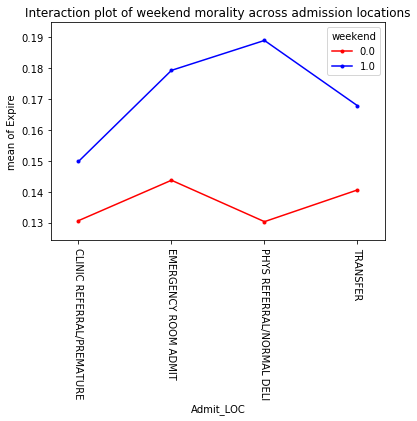

In [11]:
adj_glm_int = smf.glm('Expire ~ C(weekend) * C(Admit_LOC)', data=df, family=sm.families.Binomial()).fit()
weekend_grid = expand_grid({'weekend': [0, 1],
                            'Admit_LOC': ['EMERGENCY ROOM ADMIT', 'TRANSFER', 'CLINIC REFERRAL/PREMATURE', 'PHYS REFERRAL/NORMAL DELI']})
weekend_grid['predict'] = adj_glm_int.predict(weekend_grid[['weekend','Admit_LOC']])
weekend_grid['log_odds'] = prob2logodds(weekend_grid['predict'])
weekend_grid.set_index(['weekend','Admit_LOC'], inplace=True)
diff_grid = weekend_grid.loc[1]['log_odds'] - weekend_grid.loc[0]['log_odds']
print(np.exp(diff_grid))
print()
print('value counts')
print(df[(df.weekend==1)&(df.Expire==1)].Admit_LOC.value_counts())

fig = interaction_plot(df.Admit_LOC, df.weekend, df.Expire, colors=['red','blue'])
plt.title('Interaction plot of weekend morality across admission locations')
plt.xticks(rotation=270)
plt.show()

Admit_Unit
MICU     1.046275
CSRU     4.287452
SICU     1.241201
TSICU    0.871312
CCU      1.047383
Name: log_odds, dtype: float64

value counts
MICU     530
SICU     218
CCU      153
TSICU    153
CSRU      49
Name: Admit_Unit, dtype: int64


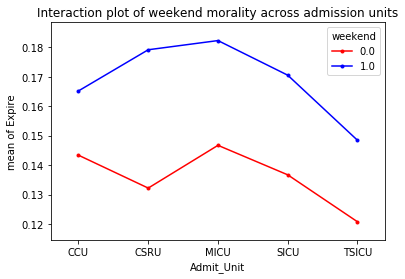

In [12]:
adj_glm_int = smf.glm('Expire ~ C(weekend) * C(Admit_Unit)', data=df, family=sm.families.Binomial()).fit()
weekend_grid = expand_grid({'weekend': [0, 1],
                            'Admit_Unit': ['MICU', 'CSRU', 'SICU', 'TSICU', 'CCU']})
weekend_grid['predict'] = adj_glm_int.predict(weekend_grid[['weekend','Admit_Unit']])
weekend_grid['log_odds'] = prob2logodds(weekend_grid['predict'])
weekend_grid.set_index(['weekend','Admit_Unit'], inplace=True)
diff_grid = weekend_grid.loc[1]['log_odds'] - weekend_grid.loc[0]['log_odds']
print(np.exp(diff_grid))
print()
print('value counts')
print(df[(df.weekend==1)&(df.Expire==1)].Admit_Unit.value_counts())
fig = interaction_plot(df.Admit_Unit, df.weekend, df.Expire, colors=['red','blue'])
plt.title('Interaction plot of weekend morality across admission units')
plt.show()

Hospital_LOS
0    1.08
1    1.30
2    1.76
3    1.11
Name: log_odds, dtype: float64

value counts
0    480
3    285
2    177
1    161
Name: Hospital_LOS, dtype: int64


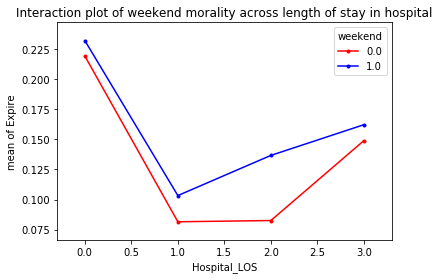

In [13]:
adj_glm_int = smf.glm('Expire ~ C(weekend) * C(Hospital_LOS)', data=df, family=sm.families.Binomial()).fit()
weekend_grid = expand_grid({'weekend': [0, 1],
                            'Hospital_LOS': [0,1,2,3]})
weekend_grid['predict'] = adj_glm_int.predict(weekend_grid[['weekend','Hospital_LOS']])
weekend_grid['log_odds'] = prob2logodds(weekend_grid['predict'])
weekend_grid.set_index(['weekend','Hospital_LOS'], inplace=True)
diff_grid = weekend_grid.loc[1]['log_odds'] - weekend_grid.loc[0]['log_odds']
print(np.round(np.exp(diff_grid),decimals=2))
print()
print('value counts')
print(df[(df.weekend==1)&(df.Expire==1)].Hospital_LOS.value_counts())
fig = interaction_plot(df.Hospital_LOS, df.weekend, df.Expire, colors=['red','blue'])
plt.title('Interaction plot of weekend morality across length of stay in hospital')
plt.show()

Primary_Diag_Code
1     10.00
2      1.12
3      1.49
4      1.17
5      0.95
6      1.67
7      1.20
8      2.11
9      1.02
10     0.85
11     1.06
12     1.00
13     3.35
14     0.39
15     0.00
17     0.88
18     0.83
Name: log_odds, dtype: float64

value counts
8     353
2     216
18    174
9     125
10     96
3      81
11     15
7      14
1       9
17      6
4       6
5       4
13      2
14      1
6       1
Name: Primary_Diag_Code, dtype: int64


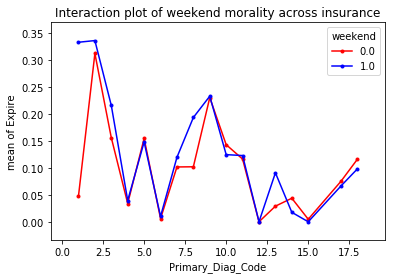

In [14]:
adj_glm_int = smf.glm('Expire ~ C(weekend) * C(Primary_Diag_Code)', data=df, family=sm.families.Binomial()).fit()
weekend_grid = expand_grid({'weekend': [0, 1],
                            'Primary_Diag_Code': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18]})
weekend_grid['predict'] = adj_glm_int.predict(weekend_grid[['weekend','Primary_Diag_Code']])
weekend_grid['log_odds'] = prob2logodds(weekend_grid['predict'])
weekend_grid.set_index(['weekend','Primary_Diag_Code'], inplace=True)
diff_grid = weekend_grid.loc[1]['log_odds'] - weekend_grid.loc[0]['log_odds']
print(np.round(np.exp(diff_grid),decimals=2))
print()
print('value counts')
print(df[(df.weekend==1)&(df.Expire==1)].Primary_Diag_Code.value_counts())
fig = interaction_plot(df.Primary_Diag_Code, df.weekend, df.Expire, colors=['red','blue'])
plt.title('Interaction plot of weekend morality across insurance')
plt.show()